In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
from PIL import Image
import random
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Analysis_Figs_V6.5.3/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri, Dataset):
    Data_DF = Open_File(Diri+Model+'_Data_'+Dataset+'_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_'+Dataset+'_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
# Edit Time Format
    Time, Begin_Time, Compl_Time, Trop_Peak_Time, Peak_Time, Birth_Time, Death_Time, Birth_Month, Begin_Month, Compl_Month = [], [], [], [], [], [], [], [], [], []
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Begin_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        Compl_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Trop_Peak_Time.append(Datetime(ET_DF["Trop Peak Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
        Birth_Time.append(Datetime(ET_DF["Genesis Time"][j]))
        Death_Time.append(Datetime(ET_DF["Dissipation Time"][j]))
        Birth_Month.append(Find_Month(ET_DF["Genesis Time"][j]))
        Begin_Month.append(Find_Month(ET_DF["ET Begin Time"][j]))
        Compl_Month.append(Find_Month(ET_DF["ET Complete Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["ET Begin Time"] = Begin_Time
    ET_DF["ET Complete Time"] = Compl_Time
    ET_DF["Trop Peak Time"] = Trop_Peak_Time
    ET_DF["Peak Time"] = Peak_Time
    ET_DF["Genesis Time"] = Birth_Time
    ET_DF["Dissipation Time"] = Death_Time
    ET_DF["Genesis Month"] = Birth_Month
    ET_DF["ET Begin Month"] = Begin_Month
    ET_DF["ET Complete Month"] = Compl_Month
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    except:
        New_Time = numpy.nan
    return (New_Time)

In [6]:
def Find_Month(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
        Month = New_Time.month
    except:
        Month = numpy.nan
    return (Month)

In [7]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)

In [8]:
Num_Years = numpy.array([90,93,93])

In [9]:
Control_Data_A, Control_ET_A, Control_Codes = Files_Open("Control", Diri, 'SubsetA')
RCP45_Data_A, RCP45_ET_A, RCP45_Codes = Files_Open("RCP45", Diri, 'SubsetA')
RCP85_Data_A, RCP85_ET_A, RCP85_Codes = Files_Open("RCP85", Diri, 'SubsetA')

In [10]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri, 'SubsetB')
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri, 'SubsetB')
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri, 'SubsetB')

In [11]:
# Function For Applying SLP Bounds
def ET_SLP_Bounds(Control_ET, RCP45_ET, RCP85_ET, Begin):
# Define SLP Bound For ET Begin and ET Complete
    Begin_SLP_Bound = 1008
    Compl_SLP_Bound = 1008
# Apply Bounds
    if Begin == True:
        Control_ET_Begin = Control_ET[Control_ET["ET Begin SLP"] <= Begin_SLP_Bound]
        RCP45_ET_Begin = RCP45_ET[RCP45_ET["ET Begin SLP"] <= Begin_SLP_Bound]
        RCP85_ET_Begin = RCP85_ET[RCP85_ET["ET Begin SLP"] <= Begin_SLP_Bound]
        return (Control_ET_Begin, RCP45_ET_Begin, RCP85_ET_Begin)
    else:
        Control_ET_Compl = Control_ET[Control_ET["ET Complete SLP"] <= Compl_SLP_Bound]
        RCP45_ET_Compl = RCP45_ET[RCP45_ET["ET Complete SLP"] <= Compl_SLP_Bound]
        RCP85_ET_Compl = RCP85_ET[RCP85_ET["ET Complete SLP"] <= Compl_SLP_Bound]
        return (Control_ET_Compl, RCP45_ET_Compl, RCP85_ET_Compl)

In [12]:
# Create Function to Plot ET Histograms For Month
def ET_Month_Histogram(Control_ET, RCP45_ET, RCP85_ET, Var, Var_Label, Title, Rela, Orient, Bins, \
    Dens_Min, Dens_Max, Dens_Width, Savefig, Figname):
    Fig = pyplot.figure(figsize=(12,8))
    Colours = ['limegreen', 'orange', 'red']
    Labels = ["Control", "RCP4.5", "RCP8.5"]
#
# Plot Month
    Axis = Fig.add_subplot(1,1,1)
    if Var == "ET Begin Month":
        Control_ET_Begin, RCP45_ET_Begin, RCP85_ET_Begin = ET_SLP_Bounds(Control_ET, RCP45_ET, RCP85_ET, True)
        pyplot.hist([Control_ET_Begin[Var], RCP45_ET_Begin[Var], RCP85_ET_Begin[Var]], density=Rela, \
        orientation=Orient, bins=Bins, color=Colours, label=Labels)
    elif Var == "ET Complete Month":
        Control_ET_Compl, RCP45_ET_Compl, RCP85_ET_Compl = ET_SLP_Bounds(Control_ET, RCP45_ET, RCP85_ET, True)
        pyplot.hist([Control_ET_Compl[Var], RCP45_ET_Compl[Var], RCP85_ET_Compl[Var]], density=Rela, \
        orientation=Orient, bins=Bins, color=Colours, label=Labels)
    elif Var == "Genesis Month":
        pyplot.hist([Control_ET[Var], RCP45_ET[Var], RCP85_ET[Var]], density=Rela, \
        orientation=Orient, bins=Bins, color=Colours, label=Labels)
    ET_Histo_Month_Formatting(Var, Var_Label, Rela, Orient, Dens_Min, Dens_Max, Dens_Width, Title)
#
# Legend
    pyplot.legend(loc=2, fontsize=15)
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [13]:
# Formatting Based on Variable
def ET_Histo_Month_Formatting(Var, Var_Label, Rela, Orient, Dens_Min, Dens_Max, Dens_Width, Title):
# Ticks and Lims
    if Orient == 'vertical':
        pyplot.xticks(Create_Bins(1,12,1))
        pyplot.xlim(0.5,12.5)
        pyplot.yticks(Create_Bins(Dens_Min, Dens_Max, Dens_Width))
        pyplot.ylim(Dens_Min, Dens_Max)
#
# Labels and Title
    if Rela == True:
        x_Label = "Proportion"
    else:
        x_Label = "Frequency"
    pyplot.ylabel(x_Label, fontsize=18)
    pyplot.xlabel(Var_Label, fontsize=18)
    pyplot.title(Title, fontsize=25)
#
# Gridlines
    pyplot.grid(linewidth=0.3, color='silver', linestyle='-')

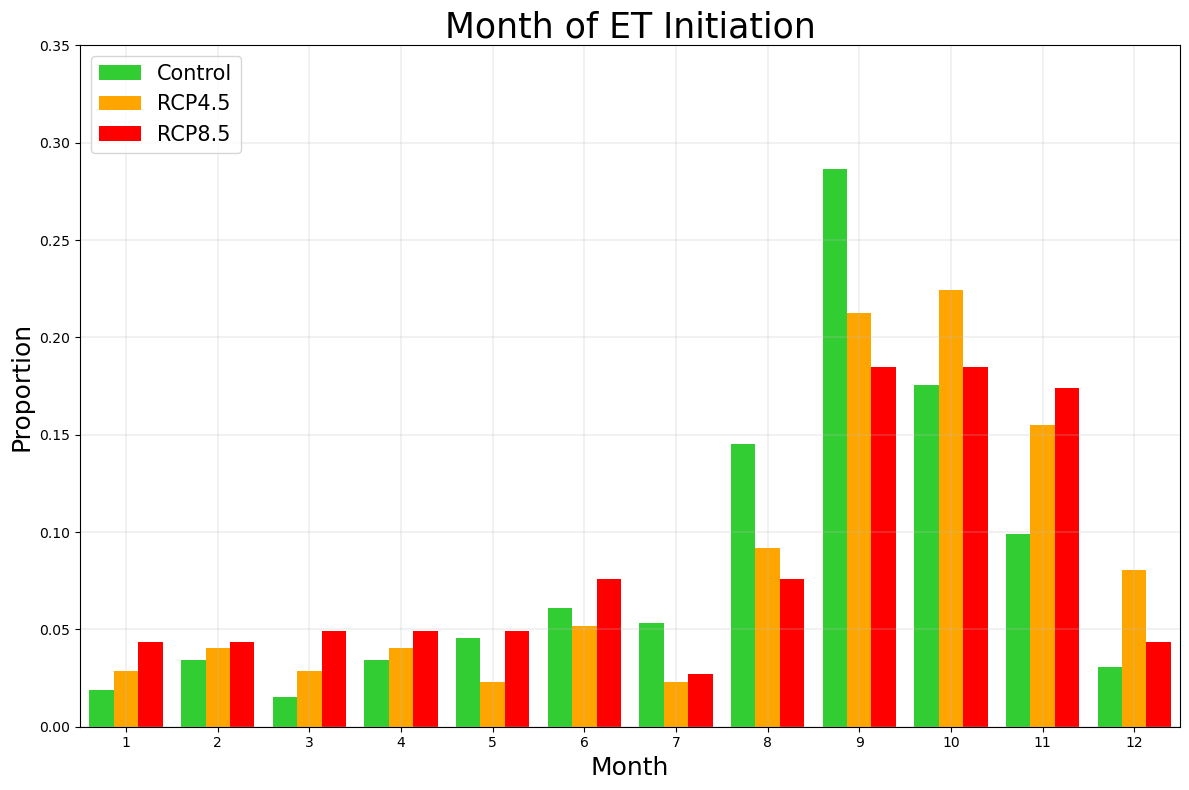

In [14]:
Var = "ET Begin Month"
Var_Label = "Month"
Title = "Month of ET Initiation"
Rela = True
Orient = 'vertical'
Bins = Create_Bins(0.5,12.5,1)
Dens_Min, Dens_Max, Dens_Width = 0, 0.35, 0.05
Savefig = True
Figname = 'ET_Begin_Month_Histo_Rela'
ET_Month_Histogram(Control_ET, RCP45_ET, RCP85_ET, Var, Var_Label, Title, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

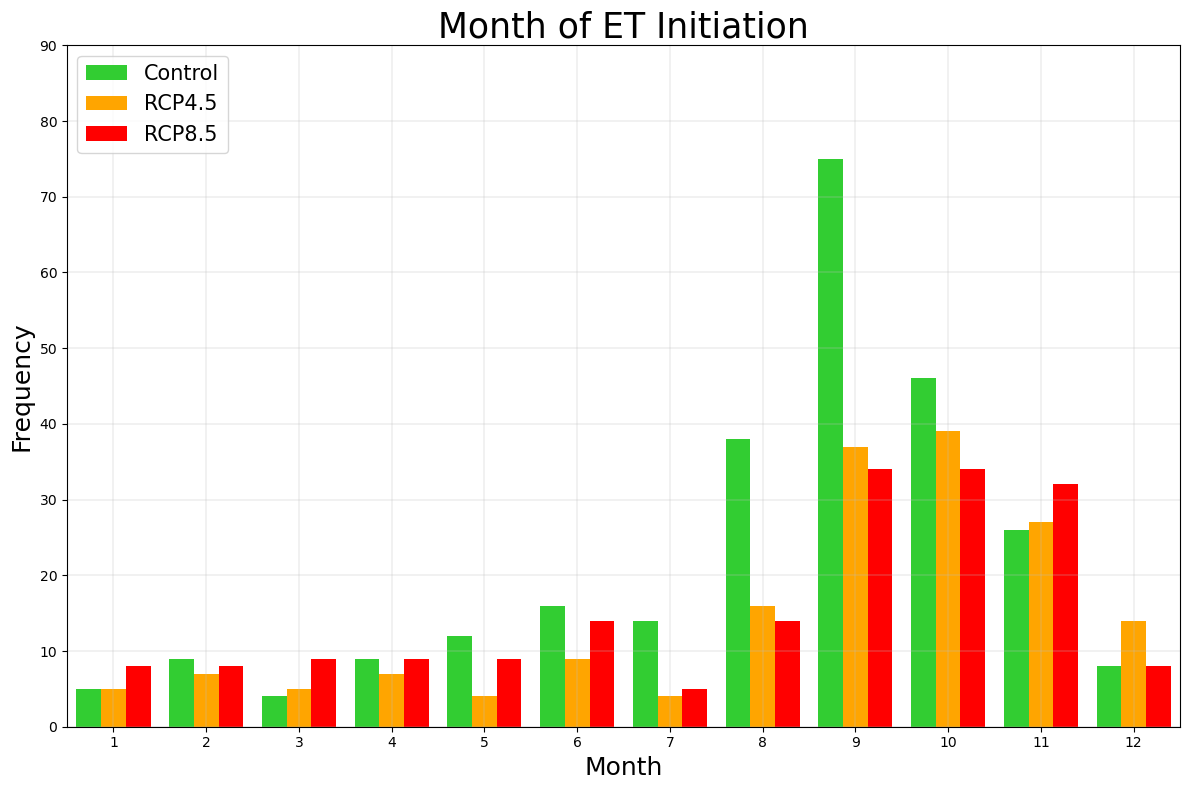

In [15]:
Var = "ET Begin Month"
Var_Label = "Month"
Title = "Month of ET Initiation"
Rela = False
Orient = 'vertical'
Bins = Create_Bins(0.5,12.5,1)
Dens_Min, Dens_Max, Dens_Width = 0, 90, 10
Savefig = True
Figname = 'ET_Begin_Month_Histo_Abs'
ET_Month_Histogram(Control_ET, RCP45_ET, RCP85_ET, Var, Var_Label, Title, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

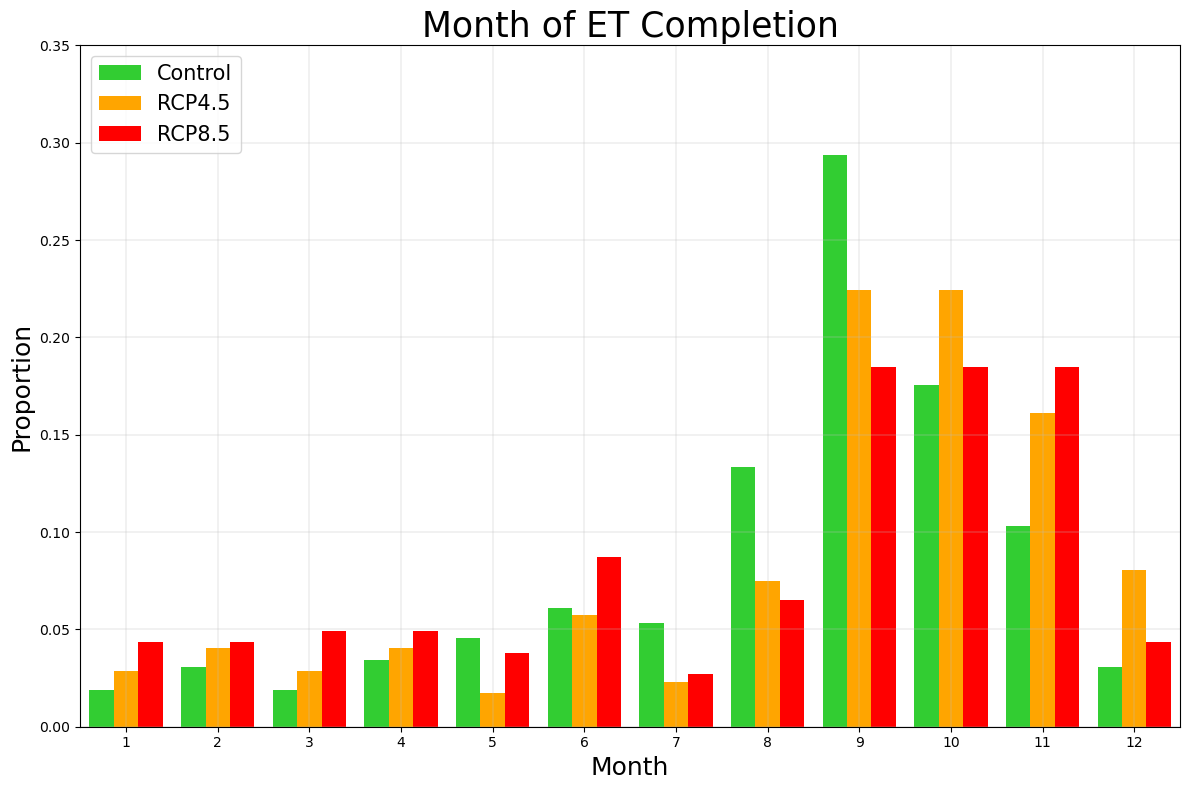

In [16]:
Var = "ET Complete Month"
Var_Label = "Month"
Title = "Month of ET Completion"
Rela = True
Orient = 'vertical'
Bins = Create_Bins(0.5,12.5,1)
Dens_Min, Dens_Max, Dens_Width = 0, 0.35, 0.05
Savefig = True
Figname = 'ET_Complete_Month_Histo_Rela'
ET_Month_Histogram(Control_ET, RCP45_ET, RCP85_ET, Var, Var_Label, Title, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

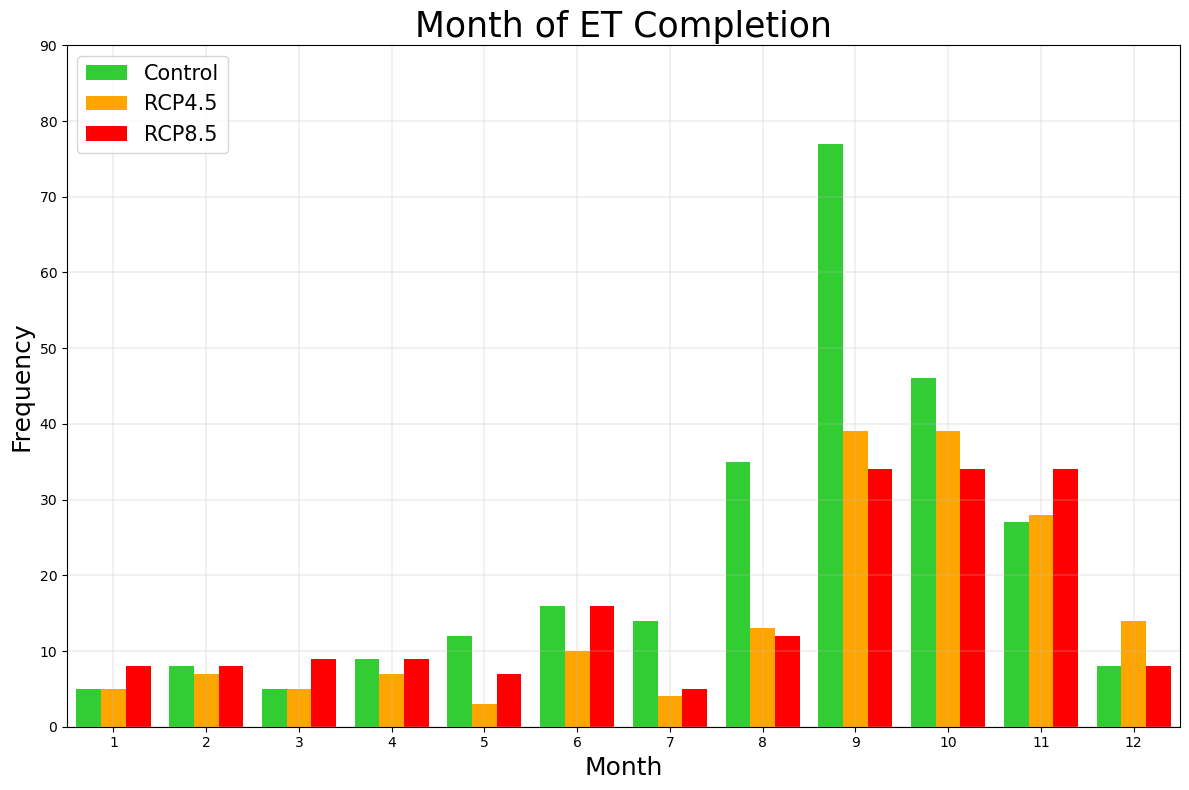

In [17]:
Var = "ET Complete Month"
Var_Label = "Month"
Title = "Month of ET Completion"
Rela = False
Orient = 'vertical'
Bins = Create_Bins(0.5,12.5,1)
Dens_Min, Dens_Max, Dens_Width = 0, 90, 10
Savefig = True
Figname = 'ET_Complete_Month_Histo_Abs'
ET_Month_Histogram(Control_ET, RCP45_ET, RCP85_ET, Var, Var_Label, Title, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

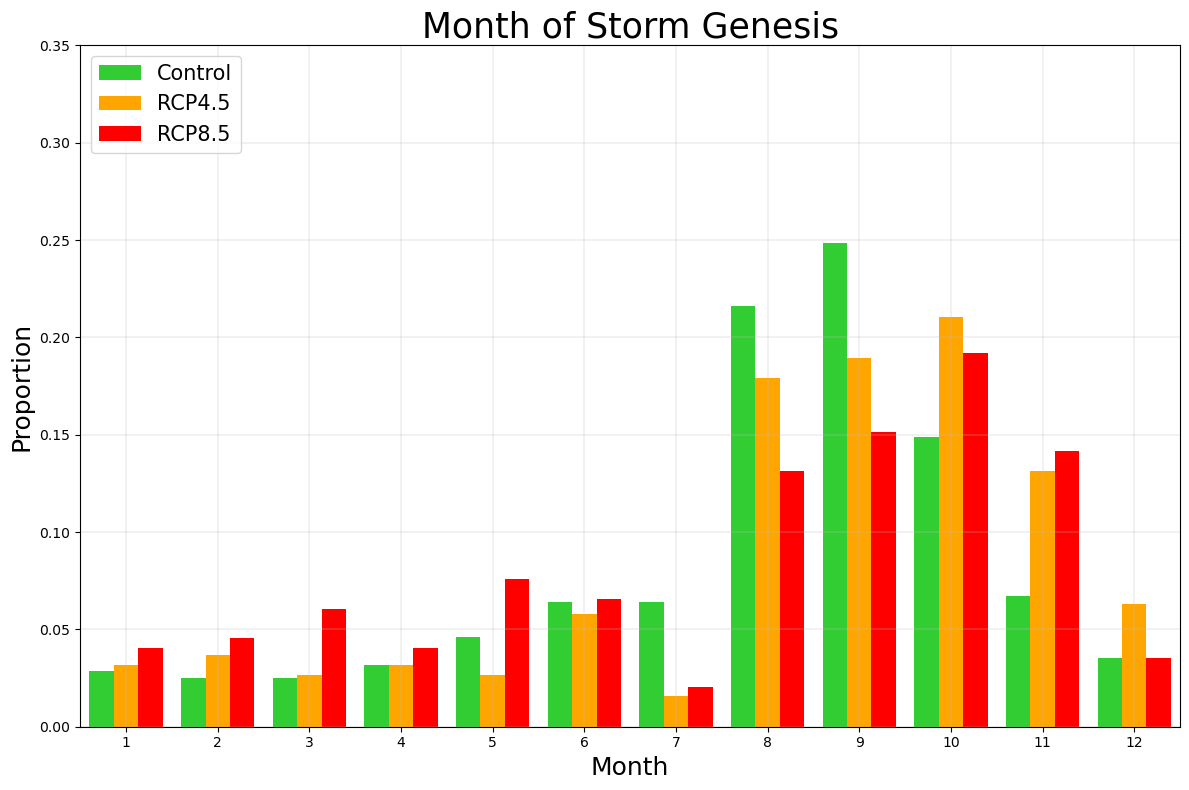

In [18]:
Var = "Genesis Month"
Var_Label = "Month"
Title = "Month of Storm Genesis"
Rela = True
Orient = 'vertical'
Bins = Create_Bins(0.5,12.5,1)
Dens_Min, Dens_Max, Dens_Width = 0, 0.35, 0.05
Savefig = True
Figname = 'Genesis_Month_Histo_Rela'
ET_Month_Histogram(Control_ET, RCP45_ET, RCP85_ET, Var, Var_Label, Title, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

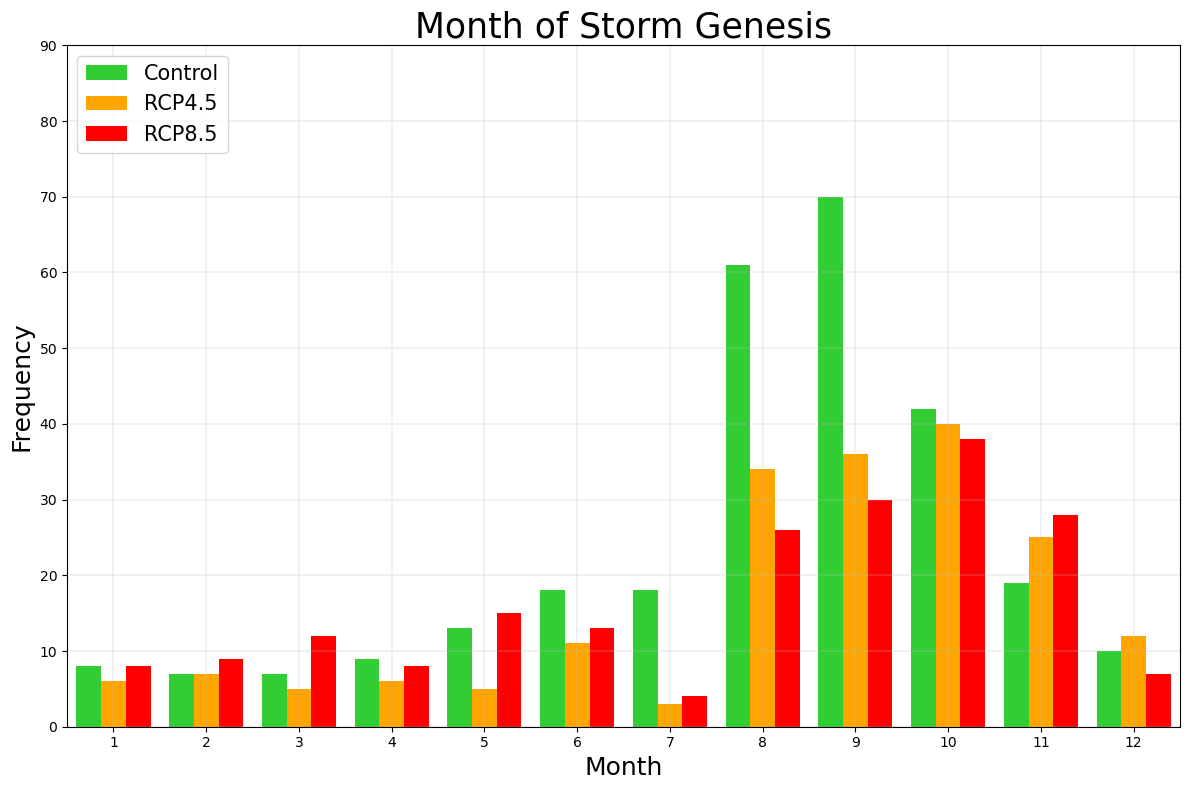

In [19]:
Var = "Genesis Month"
Var_Label = "Month"
Title = "Month of Storm Genesis"
Rela = False
Orient = 'vertical'
Bins = Create_Bins(0.5,12.5,1)
Dens_Min, Dens_Max, Dens_Width = 0, 90, 10
Savefig = True
Figname = 'Genesis_Month_Histo_Abs'
ET_Month_Histogram(Control_ET, RCP45_ET, RCP85_ET, Var, Var_Label, Title, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

In [20]:
# Count Storms Based on Genesis Month
def Count_Months(ET_DF):
    Month_Count = numpy.zeros(13)
    for i in range(12):
        Month_Count[i] = len(ET_DF[ET_DF["Genesis Month"] == i+1])
    Month_Count[12] = len(ET_DF)
# Count Storms Based on Season
#    Month_Count[12] = len(ET_DF[(ET_DF["Genesis Month"] >= 1) & (ET_DF["Genesis Month"] <= 3)])
#    Month_Count[13] = len(ET_DF[(ET_DF["Genesis Month"] >= 4) & (ET_DF["Genesis Month"] <= 6)])
#    Month_Count[14] = len(ET_DF[(ET_DF["Genesis Month"] >= 7) & (ET_DF["Genesis Month"] <= 9)])
#    Month_Count[15] = len(ET_DF[(ET_DF["Genesis Month"] >= 10) & (ET_DF["Genesis Month"] <= 12)])
    return (Month_Count)

In [21]:
# Create DataFrame to Store Months Data
def Months_DF(Control_ET_A, RCP45_ET_A, RCP85_ET_A, Control_ET, RCP45_ET, RCP85_ET):
    Months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Total']
#    , 'Jan-Mar', 'Apr-Jun', 'Jul-Sep', 'Oct-Dec'
# Use Function to Count Number of Storms in Each Month
    Control_ET_A_Months = Count_Months(Control_ET_A)
    RCP45_ET_A_Months = Count_Months(RCP45_ET_A)
    RCP85_ET_A_Months = Count_Months(RCP85_ET_A)
    Control_ET_B_Months = Count_Months(Control_ET)
    RCP45_ET_B_Months = Count_Months(RCP45_ET)
    RCP85_ET_B_Months = Count_Months(RCP85_ET)
# Calculate Percentage of ET Complete
    Control_ET_Percent, RCP45_ET_Percent, RCP85_ET_Percent = numpy.zeros(13), numpy.zeros(13), numpy.zeros(13)
    for i in range(13):
        Control_ET_Percent[i] = round(Control_ET_B_Months[i] / Control_ET_A_Months[i], 3)
        RCP45_ET_Percent[i] = round(RCP45_ET_B_Months[i] / RCP45_ET_A_Months[i], 3)
        RCP85_ET_Percent[i] = round(RCP85_ET_B_Months[i] / RCP85_ET_A_Months[i], 3)
#
# Create DataFrame
    DF = pandas.DataFrame({"Month": Months, \
    "Control Subset A": Control_ET_A_Months, "RCP4.5 Subset A": RCP45_ET_A_Months, "RCP8.5 Subset A": RCP85_ET_A_Months, \
    "Control Subset B": Control_ET_B_Months, "RCP4.5 Subset B": RCP45_ET_B_Months, "RCP8.5 Subset B": RCP85_ET_B_Months, \
    "Control ET Complete Rate": Control_ET_Percent, "RCP4.5 ET Complete Rate": RCP45_ET_Percent, \
    "RCP8.5 ET Complete Rate": RCP85_ET_Percent})
    return (DF)

In [22]:
Months_Count_DF = Months_DF(Control_ET_A, RCP45_ET_A, RCP85_ET_A, Control_ET, RCP45_ET, RCP85_ET)
Months_Count_DF

,Month,Control Subset A,RCP4.5 Subset A,RCP8.5 Subset A,Control Subset B,RCP4.5 Subset B,RCP8.5 Subset B,Control ET Complete Rate,RCP4.5 ET Complete Rate,RCP8.5 ET Complete Rate
0,Jan,27.0,17.0,21.0,8.0,6.0,8.0,0.296,0.353,0.381
1,Feb,13.0,23.0,20.0,7.0,7.0,9.0,0.538,0.304,0.450
2,Mar,25.0,19.0,26.0,7.0,5.0,12.0,0.280,0.263,0.462
3,Apr,21.0,22.0,15.0,9.0,6.0,8.0,0.429,0.273,0.533
4,May,25.0,15.0,28.0,13.0,5.0,15.0,0.520,0.333,0.536
5,Jun,33.0,15.0,20.0,18.0,11.0,13.0,0.545,0.733,0.650
6,Jul,34.0,11.0,8.0,18.0,3.0,4.0,0.529,0.273,0.500
7,Aug,128.0,68.0,54.0,61.0,34.0,26.0,0.477,0.500,0.481
8,Sep,172.0,98.0,79.0,70.0,36.0,30.0,0.407,0.367,0.380
9,Oct,97.0,85.0,58.0,42.0,40.0,38.0,0.433,0.471,0.655


In [23]:
# Calculate Statistical Significance Using Chi Square Test
def Chi_Square_Test(Vals):
    P_Val = stats.chisquare(Vals)[1]
    return (P_Val)

In [24]:
# Apply Chi Square Test For Number of Storms Each Month
def Months_Count_Test(DF, Var1, Var2):
    P_Vals = numpy.zeros(len(DF))
    for i in range(len(P_Vals)):
        Vals = [DF[Var1][i], DF[Var2][i]]
        P_Vals[i] = round(Chi_Square_Test(Vals), 3)
    return (P_Vals)

In [25]:
# Calculate Statistical Significance Using Z Test
def Z_Test(Vals_A, Vals_B):
    P_Val = proportions_ztest(Vals_B, Vals_A)[1]
    return (P_Val)

In [26]:
# Apply Z Test For ET Complete Percentages Each Month
def Months_Prop_Test(DF, VarA1, VarA2, VarB1, VarB2):
    P_Vals = numpy.zeros(len(DF))
    for i in range(len(P_Vals)):
        Vals_A = [DF[VarA1][i], DF[VarA2][i]]
        Vals_B = [DF[VarB1][i], DF[VarB2][i]]
        P_Vals[i] = round(Z_Test(Vals_A, Vals_B), 3)
    return (P_Vals)

In [27]:
# Calculate Statistical Significance of Months Statistics
def Months_Signif_Test(DF):
    Months_Count_DF = DF.copy()
    Months_Count_DF["P Values RCP4.5 A"] = Months_Count_Test(DF, "Control Subset A", "RCP4.5 Subset A")
    Months_Count_DF["P Values RCP8.5 A"] = Months_Count_Test(DF, "Control Subset A", "RCP8.5 Subset A")
    Months_Count_DF["P Values RCP4.5 B"] = Months_Count_Test(DF, "Control Subset B", "RCP4.5 Subset B")
    Months_Count_DF["P Values RCP8.5 B"] = Months_Count_Test(DF, "Control Subset B", "RCP8.5 Subset B")
    Months_Count_DF["P Values RCP4.5 Rate"] = Months_Prop_Test(DF, "Control Subset A", "RCP4.5 Subset A", "Control Subset B", "RCP4.5 Subset B")
    Months_Count_DF["P Values RCP8.5 Rate"] = Months_Prop_Test(DF, "Control Subset A", "RCP8.5 Subset A", "Control Subset B", "RCP8.5 Subset B")
    return (Months_Count_DF)

In [28]:
Months_Count_Signif = Months_Signif_Test(Months_Count_DF)
Months_Count_Signif

,Month,Control Subset A,RCP4.5 Subset A,RCP8.5 Subset A,Control Subset B,RCP4.5 Subset B,RCP8.5 Subset B,Control ET Complete Rate,RCP4.5 ET Complete Rate,RCP8.5 ET Complete Rate,P Values RCP4.5 A,P Values RCP8.5 A,P Values RCP4.5 B,P Values RCP8.5 B,P Values RCP4.5 Rate,P Values RCP8.5 Rate
0,Jan,27.0,17.0,21.0,8.0,6.0,8.0,0.296,0.353,0.381,0.132,0.386,0.593,1.000,0.694,0.537
1,Feb,13.0,23.0,20.0,7.0,7.0,9.0,0.538,0.304,0.450,0.096,0.223,1.000,0.617,0.166,0.619
2,Mar,25.0,19.0,26.0,7.0,5.0,12.0,0.280,0.263,0.462,0.366,0.889,0.564,0.251,0.901,0.180
3,Apr,21.0,22.0,15.0,9.0,6.0,8.0,0.429,0.273,0.533,0.879,0.317,0.439,0.808,0.284,0.535
4,May,25.0,15.0,28.0,13.0,5.0,15.0,0.520,0.333,0.536,0.114,0.680,0.059,0.705,0.251,0.909
5,Jun,33.0,15.0,20.0,18.0,11.0,13.0,0.545,0.733,0.650,0.009,0.074,0.194,0.369,0.217,0.454
6,Jul,34.0,11.0,8.0,18.0,3.0,4.0,0.529,0.273,0.500,0.001,0.000,0.001,0.003,0.138,0.881
7,Aug,128.0,68.0,54.0,61.0,34.0,26.0,0.477,0.500,0.481,0.000,0.000,0.006,0.000,0.755,0.952
8,Sep,172.0,98.0,79.0,70.0,36.0,30.0,0.407,0.367,0.380,0.000,0.000,0.001,0.000,0.521,0.682
9,Oct,97.0,85.0,58.0,42.0,40.0,38.0,0.433,0.471,0.655,0.374,0.002,0.825,0.655,0.611,0.007


In [29]:
Output_Diri_2 = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Output_Files/'

In [30]:
# Output DF to csv File
def Output_File(DF, File_Name):
    DF.to_csv(Output_Diri_2+File_Name)

In [31]:
Output_File(Months_Count_Signif, 'Months_Table.csv')